# Job Shop Problem (JSP)

1. GA алгоритм
2. Точный алгоритм, размерность 2xN

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Genetic Algorithm

In [8]:
from ga import genetic_search
from estimator import estimate
from functools import cmp_to_key

In [9]:
def sign(x):
    if x == 0: return 0
    return -1 if x < 0 else 1
 

def compare(l, r):
    if l[0] == r[0]:
        return sign(l[3] - r[3])
    else:
        return 0

In [10]:
n, m = 30, 15

# generate random Job Shop scheduling task
random.seed(42)
sol = []

for j in range(n):
    idxs = [k for k in range(m)]
    for i in range(m):
        sol.append((j, i, random.randint(1, 7), idxs.pop(random.randint(0, len(idxs) - 1))))

sol.sort(key=cmp_to_key(compare))

# solution from GA
random.seed(42)
best_sol, best_times = genetic_search(sol, n, m, epoches=1000, levels=5, 
                            alive=16, count=5, early_stopping=50, verbose=100)
print('Best time:', estimate(best_sol, n, m))

Epoch: 100/1000; Best sol: 372
Epoch: 200/1000; Best sol: 329
Epoch: 300/1000; Best sol: 314
Early stopping!
Best time: 314


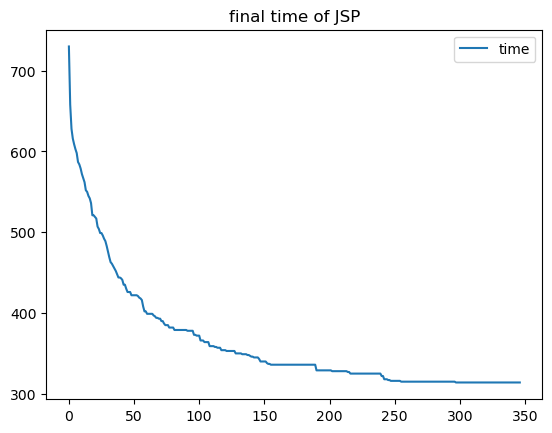

In [11]:
plt.plot(best_times, label='time')
plt.title('final time of JSP')
plt.legend()
None

In [12]:
from tqdm import tqdm

100%|██████████| 101/101 [00:20<00:00,  4.89it/s]


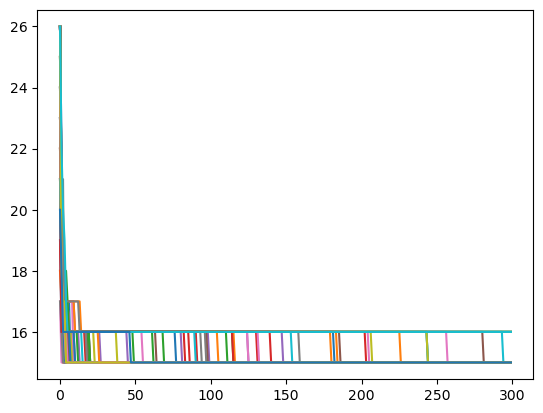

In [30]:
count = 101
max_epoches = 300

trajectories = [
    [0 for i in range(max_epoches)]
    for _ in range(count)
]

# generate random Job Shop scheduling task
random.seed(42)
sol = []

for j in range(n):
    idxs = [k for k in range(m)]
    for i in range(m):
        sol.append((j, i, random.randint(1, 7), idxs.pop(random.randint(0, len(idxs) - 1))))

sol.sort(key=cmp_to_key(compare))
       
random.seed(42)
for i in tqdm(range(count)):
    n, m = 4, 3

    best_sol, best_times = genetic_search(sol, n, m, epoches=max_epoches, levels=4, 
                                alive=12, count=3, verbose=False)
    
    for j, b in enumerate(best_times):
        trajectories[i][j] = b
    plt.plot(best_times)

In [31]:
trajectories_np = np.array(trajectories)

mean = np.mean(trajectories_np[:, -1])
std = np.std(trajectories_np[:, -1])

mean, std

(15.108910891089108, 0.31152738064459945)

15.047411478189193 15.170410303989023


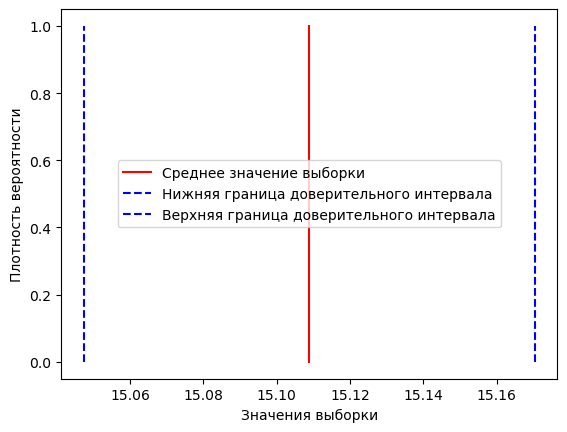

In [36]:
import scipy.stats as stats

t_critical = stats.t.ppf((1 + 0.95) / 2, df=count-1)
lower_bound = mean - (t_critical * std / (count)**0.5)
upper_bound = mean + (t_critical * std / (count)**0.5)

print(lower_bound, upper_bound)

plt.plot([mean, mean], [0, 1], 'r-', label='Среднее значение выборки')
plt.plot([lower_bound, lower_bound], [0, 1], 'b--', label='Нижняя граница доверительного интервала')
plt.plot([upper_bound, upper_bound], [0, 1], 'b--', label='Верхняя граница доверительного интервала')
plt.legend()
plt.xlabel('Значения выборки')
plt.ylabel('Плотность вероятности')
plt.show()


In [47]:
# percentiles

final_times = [t[-1] for t in trajectories]

eps = 0.05
not_opt = [t[-1] for t in trajectories if t[-1] > 15]

print(f'алгоритм не сошелся к окрестности оптимума в {len(not_opt) / len(final_times) * 100}% случаях')

алгоритм не сошелся к окрестности оптимума в 10.891089108910892% случаях


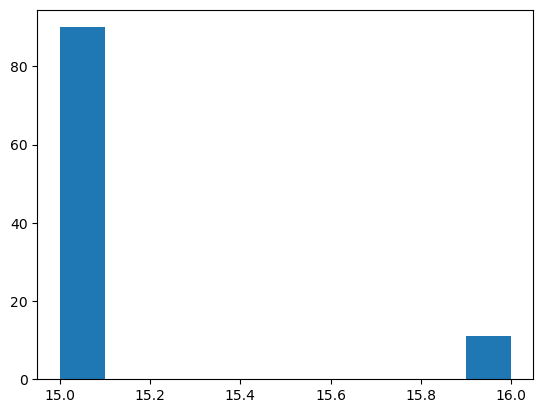

In [42]:
plt.hist(final_times)
None

In [34]:
from copy import deepcopy

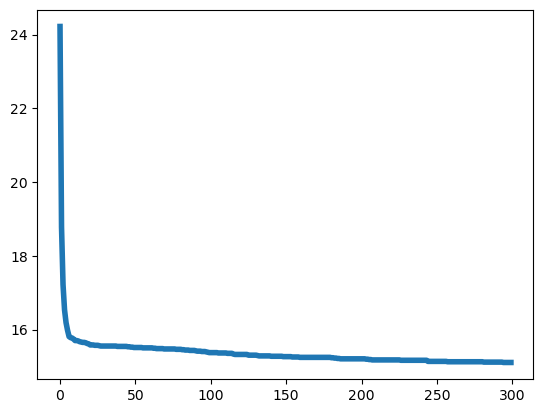

In [35]:
m = 0

ttt = deepcopy(trajectories)

for t in ttt:
    m = max(len(t), m)

for t in ttt:
    if len(t) < m:
        r = m - len(t)
        t.extend([t[-1]] * r)

ttt = np.array(ttt)
mean_trajectory = np.mean(ttt, axis=0)
plt.plot(mean_trajectory, linewidth=4, label='mean trajectory')
None

15.456336325900505 15.652574565188605


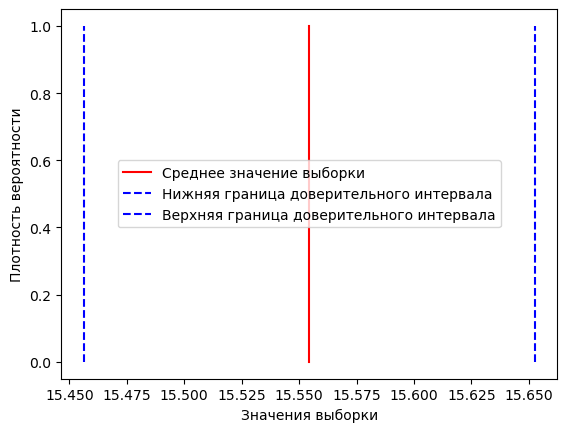

In [40]:
import scipy.stats as stats


epoch = 30 # last

mean = np.mean(trajectories_np[:, epoch])
std = np.std(trajectories_np[:, epoch])

t_critical = stats.t.ppf((1 + 0.95) / 2, df=count-1)
lower_bound = mean - (t_critical * std / (count)**0.5)
upper_bound = mean + (t_critical * std / (count)**0.5)

print(lower_bound, upper_bound)

plt.plot([mean, mean], [0, 1], 'r-', label='Среднее значение выборки')
plt.plot([lower_bound, lower_bound], [0, 1], 'b--', label='Нижняя граница доверительного интервала')
plt.plot([upper_bound, upper_bound], [0, 1], 'b--', label='Верхняя граница доверительного интервала')
plt.legend()
plt.xlabel('Значения выборки')
plt.ylabel('Плотность вероятности')
plt.show()


## Точный алгоритм

Job Shop Scheduling Problem (JSP) - это NP-полная задача комбинаторной оптимизации, и точное решение для больших инстанций может потребовать значительных вычислительных ресурсов. Однако для относительно небольших инстанций, например, с двумя машинами и небольшим количеством работ (n), можно применить точные методы решения. Вот базовая идея:

1. **Определение переменных решения:** Каждая переменная решения `x[i, j, k]` равна 1, если задача `i` выполняется на машине `j` в момент времени `k`, и 0 в противном случае. Здесь `i` - номер задачи, `j` - номер машины, `k` - момент времени.

2. **Определение целевой функции:** Целью является минимизация суммарного времени завершения выполнения всех задач:
   $\sum_{j=1}^{n} \sum_{i=1}^{2} \sum_{k=1}^{T} processing\_times[j][i] * x[j, i, k] = 1$.

3. **Ограничения:**
   - Каждая задача должна быть выполнена ровно один раз:
   $\forall j, i: \sum_{k=1}^{T} x[j, i, k] = 1$.
   - Каждая машина должна выполнять только одну задачу в каждый момент времени:
   $\forall i, k: \sum_{j=1}^{n} x[j, i, k] = 1$.
   - Preceding constraints:
   $\forall j_0, i_a, i_b: на\ i_a\ работа\ j_0\ выполняется\ раньше,\ чем\ на\ i_b\ т.е.\ \sum_{k=1}^K x[j_0, i_a, k] <= \sum_{k=1}^K x[j_0, i_b, k]\ \forall K$.

4. **Решение задачи:** Применение линейного программирования (LP) или целочисленного программирования (IP) для решения задачи.

5. **Интерпретация результата:** После решения задачи, переменные `x[i, j, k]` будут содержать информацию о том, какие задачи выполняются на каких машинах в каждый момент времени.

In [5]:
from exact_alg import solve_jsp

In [1]:
from functools import cmp_to_key


def sign(x):
    if x == 0: return 0
    return -1 if x < 0 else 1
 

def compare(l, r):
    if l[0] == r[0]:
        return sign(l[3] - r[3])
    else:
        return 0

In [6]:
n, m = 5, 2

# generate random Job Shop scheduling task
random.seed(42)
sol = []
processing_times = []

for j in range(n):
    l = []
    for i in range(m):
        t = random.randint(1, 7)
        sol.append((j, i, t))
        l.append(t)
    processing_times.append(l)

# solution from MILP
random.seed(42)
best_sol = solve_jsp(n, m, processing_times, verbose=False)
if not best_sol:
    print('No optimal solution')
print('Time:', estimate(best_sol, n, m))

Time: 19


In [ ]:
n, m = 5, 2

# generate random Job Shop scheduling task
random.seed(42)
sol = []
processing_times = []

for j in range(n):
    idxs = [k for k in range(m)]
    for i in range(m):
        sol.append((j, i, random.randint(1, 7), idxs.pop(random.randint(0, len(idxs) - 1))))
        
sol.sort(key=cmp_to_key(compare))

# not optimal solution
print('Old time:', estimate(sol, n, m))

# solution from MILP
random.seed(42)
best_sol = solve_jsp(n, m, processing_times, verbose=False)
if not best_sol:
    print('No optimal solution')
print('Time:', estimate(best_sol, n, m))